**Algorithm 4.2** Import packages, set prime p and precision M.

In [ ]:
"""This section calculates integrals ii and iv in algorithm 4.2
Paper referenced: https://services.math.duke.edu/~dasgupta/papers/comp.pdf"""

"""Note that prec needs to be adjusted based on the units and basis used. If r is large in integral ii or iv, then prec needs to be raised."""
import sympy,math, gmpy2

S = Qp(p, prec = M*4+1, type = 'capped-rel', print_mode = 'series')	#Defines the padic ring of rationals, with specified precision.
R.<y> = PowerSeriesRing(S, sparse = True)	#Allows us to write polynomials in y with coefficients in S.  

**MomentsofF1**
<div>
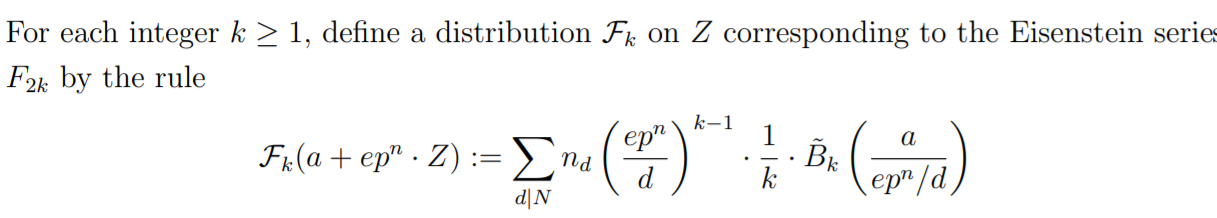
</div>

In [6]:
def momentsofF1(h,e,r,l,M,p,N):
    """ Returns the F1 moments x^-l as per Proposition 3.1, using the equation on Pg. 7. n_N = 1 and n_1 = -N"""
    total = 0
    """Note that power series is expressed in decreasing powers."""
    powerSeries = powerSeriesxToTheMinusl(l,M,h)     #This method is written below
    exponents = powerSeries.exponents()
    coeffs = powerSeries.coefficients()
    totalLen = len(exponents)

    for i in range(totalLen):
        deg = exponents[i]
        if N != 4:
            """If N is prime and unit is [N] - N[1]"""
            total += coeffs[i]*S((e*p^r/N)^deg*bernPolyTilde(deg+1, h*N/(e*p^r))/(deg+1)
                                -N*(e*p^r)^deg*bernPolyTilde(deg+1, h/(e*p^r))/(deg+1))
        else:
            """If N = 4 and unit is 2[1]-3[2]+[4]:"""
            total += coeffs[i]*S((e*p^r/4)^deg*bernPolyTilde(deg+1, h*4/(e*p^r))/(deg+1)
                                 -3*(e*p^r/2)^deg*bernPolyTilde(deg+1, h*2/(e*p^r))/(deg+1)
                                 +2*(e*p^r)^deg*bernPolyTilde(deg+1, h/(e*p^r))/(deg+1))*2
    return total

**Integral ii)**
<div>
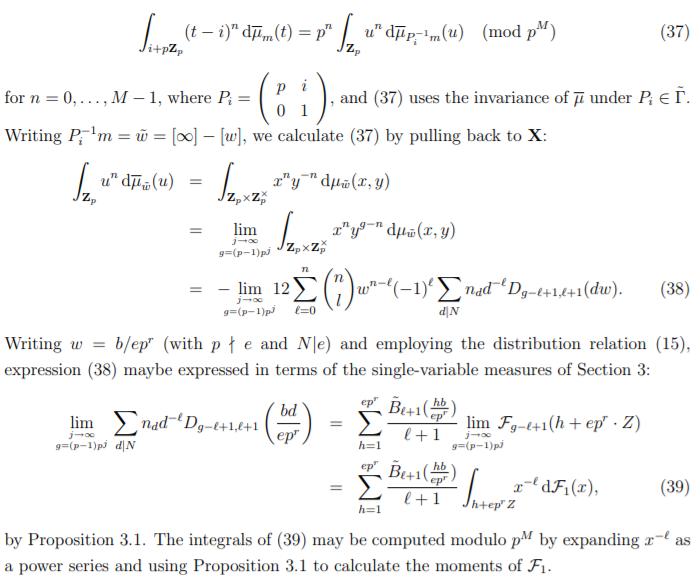
</div>
<div>
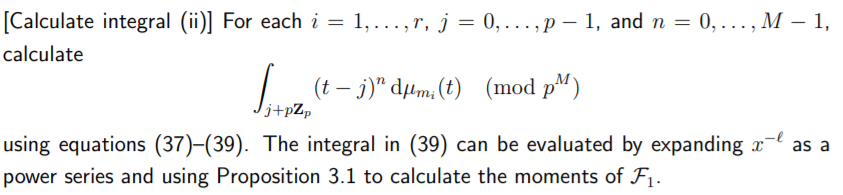
</div>

In [7]:
def bernPolyTilde(s, x):  
    """Same implementation as Algo 4.2a
    Returns: Tilde Bernoulli Polynomial (Pg.6)"""
    if s == 1 and round(x) == x:
        return 0
    else:
        return bernoulli_polynomial(x-math.floor(x),s)
    
def powerSeriesxToTheMinusl(l,M,h):
    """Power series of y^-l expanded around h to precision M.
    Used to calculate integral ii, necessary for implementing equation 39
    DO NOT input h such that p|h. """
    prec = M+math.ceil(log(M))
    power_y = 1/((y+h)^l+ O(y^(prec))) 
    power_y = power_y.polynomial()(y = y-h)
    return power_y

def integral_ii_helper(momentsofF1_dict,j,n,p,a,N,c,M):
    """j ranges from 0 to p-1, n ranges from 0 to M-1, the basis is [inf] - [a/Nc].
    Calculate w=b/ep^r. Here we can show that b = a-jN, e = N, r = 1 for our purpose. 
    Returns the value at Eqn 37.
    """
    b, e, r = a-j*N, N, 1
    
    if b%p == 0:
        b = b/p
        r = 0
        total = 0
        for l in range(n+1):
            partialSum = 0
            for h in range(1,e+1):
                newMomentSum = 0
                for h_prime in range(1,e*p+1):
                    if h_prime%p != 0 and (h-h_prime)%e == 0:
                        newMomentSum += momentsofF1_dict[(h_prime,l)]
                partialSum += bernPolyTilde(l+1, h*b/(e*p^r))*newMomentSum/(l+1)
            total -= S(gmpy2.comb(n,l) * (b/(e*p^r))^(n-l) * (-1)^l) * partialSum
    else:
        total = 0
        for l in range(n+1):
            partialSum = 0
            for h in range(1,e*p^r+1):
                if h%p != 0:
                    partialSum += bernPolyTilde(l+1, h*b/(e*p^r))*momentsofF1_dict[(h,l)]/(l+1)
            total -= S(gmpy2.comb(n,l) * (b/(e*p^r))^(n-l) * (-1)^l) * partialSum

    return p^n*total


def integral_ii_dict(p,N,M):
    """Uses helper method to calculate integral ii for each element in the basis"""
    """Creates dictionary of integrals, indexed by (i,j,n)
    i denotes the basis [inf]-[i/N], j = 0,...,p-1, n = 0,...,M-1
    We store the momentsofF1 so that we do not duplicate its calculation.
    """
    momentsofF1_dict = {}
    
    """Get and store moments of F1"""
    for h in range (1,N*p+1):
        if h%p != 0:
            for l in range(M):
                momentsofF1_dict[(h,l)] = momentsofF1(h,N,1,l,M,p,N) 
    integrals = {}
    
    """Get and store integral ii values"""
    for i in range(1,N):
        for j in range(p):
            for n in range(M):
                integrals[(i,j,n)] =  integral_ii_helper(momentsofF1_dict,j,n,p,i,N,1,M) 
                print("Calculated integral 2:%d/%d" %((i-1)*p*M+j*M+n+1,(N-1)*p*M))
    return integrals

**Integral iv)**
<div>
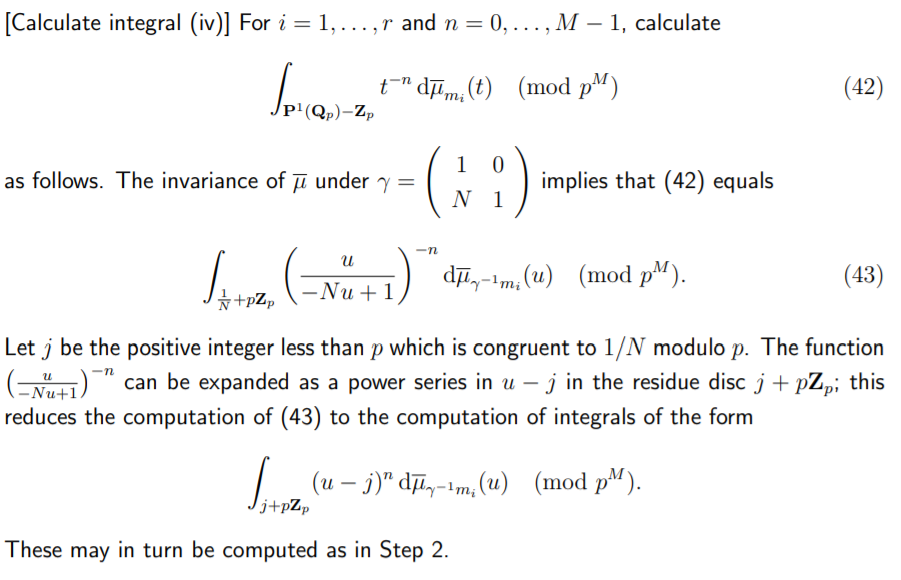
</div>

In [8]:
def powerSeriesEqn43(n,N,j,M):
    """Expanding (u/-Nu+1)^-n around j=1/N(mod p) as per Eqn. 43. 
    Necessary for calculating integral iv of algorithm 4.2. 
    Returns a power series in terms of y = (u-j). """
    prec = M+math.ceil(log(M))
    poly = ((y+j)/(1-j*N-N*y+O(y^prec)))^(-n) 
    return poly

def integral_iv_auxilliary(momentsofF1_dict,n,p,a,N,c,M):
    """Calculates using a similar method as per integral ii). 
    Returns integral of (u-j)^n, used for calculating power series in Eqn 43.
    For the part where r = 0 below, see implementation details in https://www.jstor.org/stable/40590382."""
    j = N.inverse_mod(p) 
    """Suppose the basis is [inf] - [a/Nc]. We write gamma*([inf] - [a/Nc]) = ([inf]-[a/N(c+a)])-([inf]-[1/N])"""
    total = 0
    """First do -([inf]-[1/N])
    We always have b%p = 0 since jN=1(modp)."""
    b, e, r = 1-j*N, N, 1
    if b%p == 0:
        b = b/p
        r = 0
        for l in range(n+1):
            partialSum = 0
            for h in range(1,e+1):
                newMomentSum = 0
                for h_prime in range(1,e*p+1):
                    if h_prime%p != 0 and (h-h_prime)%e == 0:
                        newMomentSum += momentsofF1_dict[(h_prime,l)]
                partialSum += bernPolyTilde(l+1, h*b/(e*p^r))*newMomentSum/(l+1)
            total += S(gmpy2.comb(n,l) * (b/(e*p^r))^(n-l) * (-1)^l) * partialSum
    else:
        total = 0
        for l in range(n+1):
            partialSum = 0
            for h in range(1,e*p^r+1):
                if h%p != 0:
                    partialSum += bernPolyTilde(l+1, h*b/(e*p^r))*momentsofF1_dict[(h,l)]/(l+1)
            total += S(gmpy2.comb(n,l) * (b/(e*p^r))^(n-l) * (-1)^l) * partialSum     
    """Now do [inf]-[a/N(c+a)]"""
    b, e, r = a-j*N*(c+a), N*(a+c), 1
    while e%p == 0:
        e = e/p
        r += 1
    while b%p == 0:
        b = b/p
        r -= 1
    """Now b,e,p should satisfy (b,p)=(e,p)=1."""
    if r == 0:
        for l in range(n+1):
            partialSum = 0
            for h in range(1,e+1):
                newMomentSum = 0
                for h_prime in range(1,e*p+1):
                    if h_prime%p != 0 and (h-h_prime)%e == 0: 
                        newMomentSum += momentsofF1_dict[(a,h_prime,l)]
                partialSum += bernPolyTilde(l+1, h*b/(e*p^r))*newMomentSum/(l+1)
            total -= S(gmpy2.comb(n,l) * (b/(e*p^r))^(n-l) * (-1)^l) * partialSum
    else:
        for l in range(n+1):
            partialSum = 0
            for h in range(1,e*p^r+1):
                if h%p != 0:
                    partialSum += bernPolyTilde(l+1, h*b/(e*p^r))*momentsofF1_dict[(a,h,l)]/(l+1)
            total -= S(gmpy2.comb(n,l) * (b/(e*p^r))^(n-l) * (-1)^l) * partialSum

    return p^n*total


def integral_iv_helper(integral_iv_aux_dict,n,p,a,N,c,M):
    """Returns integral_iv, using the power series expansion of Eqn 43, 
    and each term (u-j)^k is given in integral_iv_aux_dict."""
    j = N.inverse_mod(p) 
    """Note power series is expressed in decreasing powers."""
    powerSeries = powerSeriesEqn43(n,N,j,M)
    exponents = powerSeries.exponents()
    coeffs = powerSeries.coefficients()
    totalLen = len(exponents)
    
    total = 0
    for i in range(totalLen):
        deg = exponents[i]
        total += coeffs[i] * integral_iv_aux_dict[(a,deg)]
        
    return total
    
def integral_iv_dict(p,N,M):
    """Creates dictionary of integrals, indexed by (i,n)
    i denotes the basis [inf]-[i/N], n = 0,...,M-1
    We store the momentsofF1 so that we do not duplicate its calculation.
    """
    momentsofF1_dict = {}
    for h in range(1,N*p+1):
        if h%p != 0:
            for l in range(M+math.ceil(log(M))+1):
                momentsofF1_dict[(h,l)] = momentsofF1(h,N,1,l,M,p,N)
    
    j = N.inverse_mod(p) 
    """Only used to find total progressing in calculating moments for integral iv)."""
    totalCount = 0
    for i in range(1,N):
        b, e, r = i-j*N*(1+i), N*(i+1), 1
        while e%p == 0:
            e = e/p
            r += 1
        if b%p == 0:
            b = b/p
            r -= 1
        if r == 0:
            r += 1
        for h in range(1,e*p^r+1):
            if h%p != 0:
                for l in range(M+math.ceil(log(M))+1):
                    totalCount += 1
    count = 0
    for i in range(1,N):
        b, e, r = i-j*N*(1+i), N*(i+1), 1
        while e%p == 0:
            e = e/p
            r += 1
        if b%p == 0:
            b = b/p
            r -= 1
        if r == 0:
            r += 1
        for h in range(1,e*p^r+1):
            if h%p != 0:
                for l in range(M+math.ceil(log(M))+1):
                    momentsofF1_dict[(i,h,l)] = momentsofF1(h,e,r,l,M,p,N)
                    count += 1
                    print("Calculated moments for integral 4:%d/%d" %(count,totalCount))
            
    integral_iv_aux_dict = {} 
    for i in range(1,N):
        for n in range(M+math.ceil(log(M))+1):
            integral_iv_aux_dict[(i,n)] = integral_iv_auxilliary(momentsofF1_dict,n,p,i,N,1,M)
            print("Calculated auxilliary integral 4:%d/%d" %((i-1)*(M+math.ceil(log(M))+1)+n+1,(N-1)*(M+math.ceil(log(M))+1)))
 
    integrals = {} 
    for i in range(1,N):
        for n in range(M):
            integrals[(i,n)] = integral_iv_helper(integral_iv_aux_dict,n,p,i,N,1,M) 
            print("Calculated integral 4:%d/%d" %((i-1)*M+n+1,(N-1)*M))
    return integrals